# Import Required Libraries
Import the necessary libraries, including torch, numpy, pandas, and the custom modules for preprocessing and model definition.

Create a new conda environment with python version 3.9.19 and then run the following cells.

In [ ]:
%pip install --extra-index-url https://download.pytorch.org/whl/cu118 torch==2.2.0 numpy==1.25.1 tqdm==4.66.2 pandas==1.1.4 h5py==3.12.1 matplotlib==3.8.2 matplotlib-inline==0.1.7 click==8.1.7 scikit-learn==0.24.2 x-transformers==1.16.23 seaborn
%pip install --extra-index-url https://data.pyg.org/whl/torch-2.2.0+cu118.html torch_scatter 

In [ ]:

%pip install torch_scatter --extra-index-url https://data.pyg.org/whl/torch-2.2.0+cu118.html
%pip install transformers


In [17]:
# Import Required Libraries
import torch
import numpy as np
import pandas as pd
import os
import json
import random
import h5py
import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import matplotlib.pyplot as plt
from mortality_part_preprocessing import load_pad_separate, PairedDataset, MortalityDataset
from mortality_classification import train_test
from models.mamba import EncoderClassifierMamba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tarfile


# Load and Preprocess the Physionet Dataset
Load the Physionet dataset and preprocess it using the provided preprocessing functions.

In [18]:

# Define a custom dataset class for PhysioNet 2012
class PhysioNet2012Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
# Load and preprocess the PhysioNet 2012 dataset
def load_physionet2012(base_path, split_index):
    train_data = np.load(os.path.join(base_path, f"train_physionet2012_{split_index}.npy"), allow_pickle=True)
    val_data = np.load(os.path.join(base_path, f"validation_physionet2012_{split_index}.npy"), allow_pickle=True)
    test_data = np.load(os.path.join(base_path, f"test_physionet2012_{split_index}.npy"), allow_pickle=True)
    return train_data, val_data, test_data

# Define the dataset ID and base path
dataset_id = "physionet2012"
data_path = "./P12data/"
# Unzip the P12Data_1.tar.gz file
with tarfile.open(data_path+"P12Data_1.tar.gz", "r:gz") as tar:
    tar.extractall(path=data_path)

base_path = "./P12data/split_1"


# Load and preprocess the dataset
train_pair, val_data, test_data = load_pad_separate(dataset_id, base_path, split_index=1)

# Display the shapes of the datasets
print(f"Training pairs: {len(train_pair)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Preprocessed files not found. Preprocessing the dataset...
Loading dataset
Preprocessing dataset


100%|██████████| 9590/9590 [00:22<00:00, 421.82it/s]


shape of active data = torch.Size([9590, 37, 215])
shape of time data = torch.Size([9590, 215])
shape of static data = torch.Size([9590, 8])
Preprocessing dataset


100%|██████████| 9590/9590 [00:21<00:00, 438.20it/s]


shape of active data = torch.Size([9590, 37, 215])
shape of time data = torch.Size([9590, 215])
shape of static data = torch.Size([9590, 8])
Preprocessing dataset


100%|██████████| 1199/1199 [00:02<00:00, 443.20it/s]


shape of active data = torch.Size([1199, 37, 215])
shape of time data = torch.Size([1199, 215])
shape of static data = torch.Size([1199, 8])
Preprocessing dataset


100%|██████████| 1199/1199 [00:02<00:00, 456.45it/s]


shape of active data = torch.Size([1199, 37, 215])
shape of time data = torch.Size([1199, 215])
shape of static data = torch.Size([1199, 8])
shape of active data = torch.Size([1342, 37, 215])
shape of time data = torch.Size([1342, 215])
shape of static data = torch.Size([1342, 8])
shape of labels = torch.Size([1342])
shape of active data = torch.Size([8248, 37, 215])
shape of time data = torch.Size([8248, 215])
shape of static data = torch.Size([8248, 8])
shape of labels = torch.Size([8248])
Saving datasets to ./processed_datasets
Training pairs: 4026
Validation data: 1199
Test data: 1199


# Define the Mamba Model
Define the Mamba model architecture using the provided Mamba model class.

In [19]:
# Define the Mamba Model

# Define the Mamba model architecture using the provided Mamba model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Mamba model with the specified parameters
mamba_model = EncoderClassifierMamba(
    device=device,
    pooling="mean",
    num_classes=2,
    sensors_count=37,
    static_count=8,
    layers=3,
    d_model=256,
    ssm_state_size=64,
    expand_factor=1,
    dropout=0.2
).to(device)

# Print the model architecture
print(mamba_model)

EncoderClassifierMamba(
  (mamba_model): Mamba2ForCausalLM(
    (backbone): Mamba2Model(
      (embeddings): Embedding(0, 256)
      (layers): ModuleList(
        (0-2): 3 x Mamba2Block(
          (norm): Mamba2RMSNorm()
          (mixer): Mamba2Mixer(
            (act): SiLU()
            (conv1d): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
            (in_proj): Linear(in_features=256, out_features=641, bias=False)
            (norm): MambaRMSNormGated()
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
          )
        )
      )
      (norm_f): Mamba2RMSNorm()
    )
    (lm_head): Linear(in_features=256, out_features=0, bias=False)
  )
  (sensor_embedding): Linear(in_features=74, out_features=256, bias=True)
  (static_embedding): Linear(in_features=8, out_features=8, bias=True)
  (nonlinear_merger): Linear(in_features=264, out_features=264, bias=True)
  (classifier): Linear(in_features=264, out_features=2, bias=True)
  (t

# Train the Mamba Model
Train the Mamba model for a few epochs to demonstrate the training process.

In [20]:
# Train the Mamba Model

# Define training parameters
output_path = "./ehr_classification_results/"
epochs = 1  # Train for a few epochs to demonstrate the training process
batch_size = 64
lr = 0.001
patience = 2
early_stop_criteria = "f1-score"
loss_function = "bce_with_logits"

In [21]:


# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Train the Mamba model
loss, accuracy_score, auprc_score, auc_score, f1_score = train_test(
    train_pair=train_pair,
    val_data=val_data,
    test_data=test_data,
    output_path=output_path,
    model_type="mamba",
    model_args={
        "pooling": "mean",
        "layers": 4,
        "mamba_d_model": 256,
        "mamba_state_size": 64,
        "mamba_expand_factor": 1,
        "dropout": 0.2
    },
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    patience=patience,
    early_stop_criteria=early_stop_criteria,
    loss_function=loss_function
)

# Display the training results
print(f"Training completed with the following results:")
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy_score}")
print(f"AUPRC: {auprc_score}")
print(f"AUROC: {auc_score}")
print(f"F1 Score: {f1_score}")

# of trainable parameters: 1018798


100%|██████████| 126/126 [25:20<00:00, 12.07s/it]


Epoch: 1, Train Loss: 0.8663883767430745, Val Loss: 0.515946090221405
Validation loss decreased (inf --> 0.596708).  Saving model ...


/Users/maxbrazhnyy/Downloads/Selective_SSM_for_EHR_Classification-main/.conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.49822938442230225
{'0': {'precision': 0.9355555555555556, 'recall': 0.8190661478599222, 'f1-score': 0.8734439834024897, 'support': 1028}, '1': {'precision': 0.3779264214046823, 'recall': 0.6608187134502924, 'f1-score': 0.4808510638297872, 'support': 171}, 'accuracy': 0.7964970809007507, 'macro avg': {'precision': 0.656740988480119, 'recall': 0.7399424306551072, 'f1-score': 0.6771475236161385, 'support': 1199}, 'weighted avg': {'precision': 0.8560271302513026, 'recall': 0.7964970809007507, 'f1-score': 0.8174528330714371, 'support': 1199}}
[[842 186]
 [ 58 113]]
Accuracy = 0.7964970809007507
AUPRC = 0.45474723074989554
AUROC = 0.8228491137051448
F1_Score = 0.4808510638297872
Training completed with the following results:
Loss: 0.49822938442230225
Accuracy: 0.7964970809007507
AUPRC: 0.45474723074989554
AUROC: 0.8228491137051448
F1 Score: 0.4808510638297872


# Evaluate the Mamba Model
Evaluate the trained Mamba model on the test dataset and display the results.

In [23]:
# Evaluate the Mamba Model

# Load the best model from the training process
mamba_model.load_state_dict(torch.load(f"{output_path}checkpoint.pt", map_location=torch.device('cpu')), strict=False)

# Set the model to evaluation mode
mamba_model.eval()

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, collate_fn=MortalityDataset.non_pair_collate_fn_truncate, pin_memory=True)

# Initialize lists to store the true labels and predictions
true_labels = []
predictions = []
all_probs = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for batch in tqdm.tqdm(test_dataloader, total=len(test_dataloader)):
        data, times, static, labels, mask, delta = batch
        data, times, static, mask, delta = data.to(device), times.to(device), static.to(device), mask.to(device), delta.to(device)
        
        # Get model predictions
        outputs = mamba_model(x=data, static=static, time=times, sensor_mask=mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        
        # Store the true labels, predictions, and probabilities
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert all_probs to a numpy array
all_probs = np.array(all_probs)

# Ensure the lengths of true_labels and all_probs match
assert len(true_labels) == len(all_probs), f"Length mismatch: {len(true_labels)} true labels vs {len(all_probs)} probabilities"




/Users/maxbrazhnyy/Downloads/Selective_SSM_for_EHR_Classification-main/.conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 19/19 [03:16<00:00, 10.37s/it]


Evaluation Results:
Accuracy: 0.7964970809007507
AUROC: 0.8228491137051448
AUPRC: 0.45474723074989554
F1 Score: 0.4808510638297872


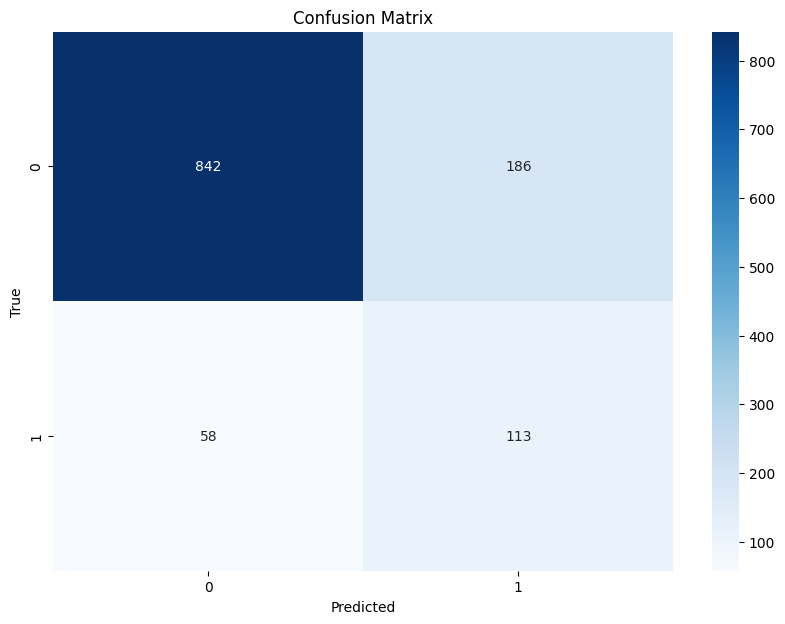

In [26]:
import seaborn as sns

# Calculate evaluation metrics
accuracy = metrics.accuracy_score(true_labels, predictions)
auroc = metrics.roc_auc_score(true_labels, all_probs[:, 1])
auprc = metrics.average_precision_score(true_labels, all_probs[:, 1])
f1 = metrics.f1_score(true_labels, predictions)

# Display the evaluation results
print(f"Evaluation Results:")
print(f"Accuracy: {accuracy}")
print(f"AUROC: {auroc}")
print(f"AUPRC: {auprc}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()